# From Hardware and infrastructure information to carbon emission when training a deep learning program

---

Master 2 Informatique - Université de Bordeaux
Image et Son  - Image Processing and Computer Vision

---
Authors : Lucia Bouza and Aurélie Bugeau
Acknowledgments : Anne-Laure Ligozat

---

## **NOTA** ##
Quise correr el notebook de manera local, utilizando la GPU de mi máquina personal, pero tuve problemas con 2 cosas. En primer lugar, no pude hacer que la GPU estuviese disponible para pytorch, aún instalando CUDA y cuDNN, por lo que podría haberlo corrido únicamente con CPU. Y, en segundo lugar, por alguna razón el comando `date = subprocess.check_output('date +%Y-%m-%dT%H:%M:%S', shell=True)` corría eternamente y no terminaba nunca. Intenté arreglarlo, pero no estaba pudiendo y al final no me iba a dar el tiempo para entregar a tiempo.

## Introduction

This practical session explains some tools for measuring the environmental impacts of deep learning code.
In this practice, you will measure a part of greenhouse gas emissions (GHG) related to energy consumption from computer calculations (training and testing).
You will calculate the carbon footprint produced by the training of a digit classification network using:


#### Online tool: Green Algorithm
Green Algorithm is an online tool: https://www.green-algorithms.org. The tool requires the entry of various data in order to measure the environmental impact of the executed code. This notebook will explain how to obtain this data.

#### Software tool: Code Carbon
Code Carbon is a Python library to measure carbon emissions. The notebook will explain how to install and use the library, as well as visualize the results.

<span style="color:DarkRed"> **You will run every command of the following practice both in google colab or your personal computer.** </span>

> Remark: If you choose your personal computer, you are in charge of install all packages.

## A - Collecting hardware infos

This section will explain how to collect the necessary data for the use of the online tool Green Algorithms. Some of the necessary data is related to the hardware on which the deep learning program is trained. This part explains how to obtain this information depending on the operating system.

> Remark: if you are running on Google Colab's, remember that notebook platform runs on Linux virtual machines.

With green algorithm, the energy consumption is computed as follows:
$$C_{total} = run_{time} \times \rm{PUE} \times \rm{PSF} \times \left(P_{memory}+\sum_{c\in {cores}} P_{c}\times \rm{usage}_c\right) \tag{1}$$
where
- $run_{time}$ is the running time in hours
- $\rm{PUE}$ is the Power Usage Effectiveness. It is an efficiency coefficient of the data center.
- $\rm{PSF}$ is the Pragmatic Scaling Factor. This parameter is used to indicate how many times we have executed the code with the indicated configuration.
- $P_{memory}$ is the power consumed by the memory in Watt.
- $cores$ is the set of all CPU and GPU cores
- $P_{c}$ is the power consumed by core $c$ (CPU or GPU) in Watt.
- $\rm{usage}_c$ is the usage factor of core $c$, between $0$ and $1$.


The *carbon footprint* is calculated according to the following formula:
$$CarbonFootprint = C_{total} \times CI \tag{2}$$
where
- $CI$ is the carbon intensity of the region where the code is being run

In the following, we will explain how all these variables can be estimated. To do so, it is necessary to determine what platform we are running the notebook on. We can be running the code on our local computer, on an on-premises server, or in the cloud. Depending on the platform, we may be sharing resources with other processes, and there may also be other energy consuming elements involved. For example: storage, network devices, air conditioners, etc. If we are running the notebook on Colab, then we are running the code on GCP (Google Cloud Platform). If we are running it on our computer in Jupyter notebook then we are running it locally. There is also the possibility of running the notebook on a server of our educational institution or work. In this case, it is important to ask if the server is in a local datacenter or in the cloud.


### A.1 Cores

> Remark: If you are working in Colab, you can choose to run the code with CPU, GPU or TPU by choosing the option in *Runtime > Change runtime type*.

#### CPU

To know the number of available CPUs and the model on the machine where you are running your program, you can execute the following commands.

- **Linux**: `cat /proc/cpuinfo` will display information about the available CPUs. To make the information easy to read, we use the following script that determines the number of configured physical and logical CPUs.
- **MacOS**: `sysctl -n machdep.cpu.brand_string` will display Chip Brand, Processor Type, Chip Model and CPU Speed. Detailed info on cpu can further be obtained with the command `sysctl -a | grep machdep.cpu`. Other option can be browsing: **System Settings > General > About > Processor.**
- **Windows**: `wmic cpu get name, numberofcores` will display same information as MacOS command. Other option can be browsing: **Task Manager > Performance > CPU.**

Run the following command and observe the result</span>

In [ ]:
!cat /proc/cpuinfo | \
awk -v FS=':' '                                       \
  /^physical id/ { if(nb_cpu<$2)  { nb_cpu=$2 } }     \
  /^cpu cores/   { if(nb_cores<$2){ nb_cores=$2 } }   \
  /^processor/   { if(nb_units<$2){ nb_units=$2 } }   \
  /^model name/  { model=$2 }                         \
                                                      \
  END{                                                \
   nb_cpu=(nb_cpu+1);                                 \
   nb_units=(nb_units+1);                             \
                                                      \
   print "CPU model:",model;                          \
   print nb_cpu,"CPU,",nb_cores,"physical cores per CPU, total",nb_units,"logical CPU units" \
 }'

CPU model:  Intel(R) Xeon(R) CPU @ 2.00GHz
1 CPU,  1 physical cores per CPU, total 2 logical CPU units


> Remark: In virtual machines the information in the /proc/cpuinfo file may not be correct, and may represent some characteristics of the CPU emulated by the virtualizer. Unfortunately, from the virtual environment there is no way to know exactly the real CPU that is being used for the execution.

#### GPU

Knowing the number and model of GPUs, can be done in the following ways:

- **Linux**: `lshw -C display`
- **MacOS**: browse: **System Settings > General > About > Graphics**
- **Windows**: browse: **Task Manager > Performance > GPU**


> Remark: The virtual machine used by Colab does not have some Linux commands. We know that the GPUs used by Colab are Nvidia, so we can use the nvidia-specific command:`!nvidia-smi -L`. This will show the number of available GPUs and their model and UUID. In this case there is only one GPU and the model is Tesla T4.

Run the following command and observe the result</span>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-60c9e7f5-54b7-9362-57d1-74432d6e9e4c)


#### Computing energy from cores

To compute $P_c$ , Green Algorithms use the Thermal Design Power (**TDP**) of the model of the processing unit provided by the manufacturer. A core power usage is assumed to be equal to the TDP divided by the number of cores (if a chip has 2 cores and a TDP of 50W, then the TDP per core is 25).

TDP is a specification that indicates the maximum amount of power that a computer processor (CPU or GPU) can dissipate when operating at its maximum performance. It refers to the power consumption under the maximum theoretical load.

In general, CPUs with a higher number of cores will have a higher TDP because they require more power to operate at maximum performance. This is because each core in a CPU requires power to perform calculations, and the more cores a CPU has, the more power it will require. However, the relationship between TDP and the number of cores is not always straightforward. Some CPUs may have a lower TDP even though they have more cores, because they are designed to operate at a lower clock speed or have more efficient architecture. Similarly, some CPUs may have a higher TDP even though they have fewer cores, because they are designed to operate at a higher clock speed or have a less efficient architecture.

If the **CPU or GPU model is not listed**,  Green Algorithms uses an average of 12 W per core.

> Remark: Remember that for virtual environments, it is necessary to know the actual CPU, and the percentage of that CPU allocated to the virtual machine. In the event that this value cannot be obtained (as is the case in Colab), take an average value, but keep in mind that the data obtained will not be completely accurate.

### A.2 Memory

According to  <a name="cite_ref-1"></a>[[1]](#cite_note-1) GPUs are responsible for around 70% of power consumption, CPU for 15%, and RAM for 10%.
Some tools like Green-Algorithms consider that power consumption of RAM depends strongly on the available memory, independently of the memory consumed.

We can check the amount of available memory using the following commands:

- **Linux**: `grep MemTotal /proc/meminfo`. The command returns the value in KB. It will be necessary to convert it to GB to use the tool (1 GB = 1024 MB = 1048576 KB).
- **MacOS**: `system_profiler SPHardwareDataType | grep "Memory:"`. Other option  can be browsing: **System Settings > General > About > Memory.**
- **Windows**: `systeminfo | findstr /C:"Total Physical Memory"`. The command returns the value in MB, it will be necessary to convert it to GB to use the tool. Other option  can be browsing: **Task Manager > Performance > Memory**


Green Algorithms, considers a consumption of 0.3725 W per GB of memory available (if we have all the server memory available, it will account for all the server memory. If we are in an HPC cluster, it will account only for the amount of memory requested, regardless of how much the process consumes). The value 0.3725 was obtained experimentally <a name="cite_ref-2"></a>[[2]](#cite_note-2).

Run the following command and observe the result.

In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       13294208 kB


In [ ]:
13294208/1024/1024

12.6783447265625

### A.3 Run time  and usage factor $usage_c$

The *run time* (or real time) refers to the duration of execution of the process, like using a stop watch.

The *process time* is the amount of time during which a core (CPU, GPU or TPU) is used for processing instructions of a computer program. The total process time is the combination of the amount of time the cores spent performing some action for a program and the amount of time they spent performing system calls for the kernel on the program's behalf. <a name="cite_ref-3"></a>[[3]](#cite_note-3).
$$ process_{time} = user_{time} + system_{time} $$

The cores usage factor is then the percentage of all available cores the job got, calculated as:
$$ usage_{c} = \frac{process_{time}}{(run_{time} * number_{cores})} $$


When hyperthreading is available and enabled, the hardware components of one physical core are shared between several threads. Each thread has at least its own set of registers. Most resources of the core (arithmetic and logic unit, floating point unit, cache) are shared between the threads. Estimating the real usage can be difficult in this scenario. According to some studies, the maximum capacity is up to 30% more than without hyperthreading.
So, when we have logical processors, we can consider consider $ number_{cores} = 1.3 * number_{pyhisical\_cores} $


We can measure the process time of the CPUs and the real time spent by the code with the `time` command (on Linux and MacOS). Unfortunately there is no similar command for Windows. It will be necessary to use language-specific libraries as `psutil` for Python. We will see an example below to use both methods.

#### Measuring real time and CPU time when training a network

To run experiments, you will use the code in `TrainingClassification.py` which trains a hand-written digit classification model.

The training is done in 5 epochs and normally takes less than a minute on different infrastructures. This experiment runs on a single GPU if any.
To get the process time used by the script, it is possible to use the command  `time`. The total time spent by the script corresponds with the real value (run time). The CPU time will be the sum of the user and sys values.

In [ ]:
!time python TrainingClassification.py

100% 9912422/9912422 [00:00<00:00, 250419886.55it/s]
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

100% 28881/28881 [00:00<00:00, 194127714.46it/s]
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

100% 1648877/1648877 [00:00<00:00, 70082602.67it/s]
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

100% 4542/4542 [00:00<00:00, 39118128.89it/s]
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/5], Train Loss: 1.9792, Train Acc: 0.5429, Val Loss: 1.5095, Val Acc: 0.7241
Epoch [2/5], Train Loss: 1.1545, Train Acc: 0.7759, Val Loss: 0.8690, Val Acc: 0.8280
Epoch [3/5], Train Loss: 0.7517, Train Acc: 0.8405, Val Loss: 0.6314, Val Acc: 0.8647
Epoch [4/5], Train Loss: 0.5876, Train Acc: 0.8663, Val Loss: 0.5191, Val Acc: 0.8815
Epoch [5/5], Train Loss: 0.5021, Train Acc: 0.8795, Val Loss: 0.4551, Val Acc: 0.8915

real	0m58.755s
user	0m46.980s
sys	0m1.869s


It is also possible to use the libraries `psutil` and `time` to measure the time used by the script, and to obtain the process time. An example is provided in `TrainingClassification_withtime.py`. The total time spent by the script corresponds to the real value. The CPU time will be the sum of the user and sys values.

In [ ]:
!python TrainingClassification_withtime.py

------------------------------------------------------
DATE INIT:  2023-09-29T01:59:49

Epoch [1/5], Train Loss: 1.9788, Train Acc: 0.5315, Val Loss: 1.5124, Val Acc: 0.7097
Epoch [2/5], Train Loss: 1.1698, Train Acc: 0.7567, Val Loss: 0.8942, Val Acc: 0.8109
Epoch [3/5], Train Loss: 0.7758, Train Acc: 0.8283, Val Loss: 0.6533, Val Acc: 0.8568
Epoch [4/5], Train Loss: 0.6054, Train Acc: 0.8588, Val Loss: 0.5332, Val Acc: 0.8737
Epoch [5/5], Train Loss: 0.5122, Train Acc: 0.8760, Val Loss: 0.4618, Val Acc: 0.8876
------------------------------------------------------
DATE END:  2023-09-29T02:00:36

------------------------------------------------------
Real Time: 46.9740 seconds
User Time: 55.2900 seconds
System Time: 3.0400 seconds


Some small differences can be seen between the two methods.

<span style="color:DarkRed">Q1. Compute de CPU usage, using last run. </span>

**Respuestas**

$process_{time} = 55.29sec + 3.04sec = 58.33sec$

$number_{cores} = 1.3\times number_{physical cores} = 1.3$

$run_{time} = 46.974sec$

$usage_c = \frac{58.33} {1.3\times46.974} = 0.955$




#### Measuring GPU time when training a network

Unfortunately, there is no tool that can be used with the command line that gives us the total time of the script (whole time), the CPU time and the GPU time, in order to calculate the CPU and GPU usage factor required by Green-Algorithms.  



To measure the process time of GPUs, you may use the tool [NVIDIA Nsight Compute](https://developer.nvidia.com/nsight-compute) , when available. You need to add the time of all the child processes that are using the GPU. To make the task easier, we can send the data to a CSV file and perform the sum there.
`!ncu --csv --metrics gpu__time_active  --target-processes all python TrainingClassification.py >> gpu.csv`

[NVIDIA Nsight Compute](https://developer.nvidia.com/nsight-compute) can be used to measure GPU time, but requires the `libnvfuser_codgen.so` library, which is not present in Colab.

One option is to take empirical and specific measurements of the use of the GPU during the execution of their algorithm using the `nvidia-smi` tool, and extrapolate that value of GPU utilization to the entire execution. It is important to note that this utilization percentage corresponds to the total utilization, and not just the utilization of the process. There could be other processes running on the available GPUs.
The python script `TrainingClassification_withtime.py` has a call to `nvidia-smi` in each epoch, leaving it's output in the file `nvidiaFile`.

Up to our knowledge, there is also no tool that measures GPU time or GPU utilization for *non-Nvidia GPUs*.


<span style="color:DarkRed">Q2. Observe the output file `nvidiaFile`. What is the mean  GPU utilization? </span>

Dado que se utiliza un 3% de la memoria disponible de la GPU en 1 época, y 5% en las 4 épocas restantes, la utilización media de la GPU, calculada como el promedio de las utilizaciones para cada época, es $\frac{1\times3 + 4\times5}{5} = 4.6$%.

## B. Practice with Green Algorithms

<span style="color:DarkRed">Q3. Using http://calculator.green-algorithms.org/, compute energy consumption for the program `TrainingClassification.py`, considering you are running in Uruguay, with $PUE=1$ and $\rm{PSF}=1$. </span>

**Respuestas**

Considerando:
- $run_{time} = 58.755sec =  0.00hrs: 0.97925min$
- $number_{cores} = 1.3\times number_{physical cores} = 1.3$
- TDP = 12W (promedio)
- GPU: 1 NVIDIA Tesla T4
- Memoria disponible: 12.68GB
- $process_{time} = 46.98sec + 1.869sec = 48.849sec$
- $usage_c = \frac{50.691} {1.3\times61.129} = 0.640$
- $usage_{GPU} = 0.046$ (promedio)
- PUE = PSF = 1

El consumo de energía es de **0.293Wh**, con una huella de carbono de 37.**74mgCO2e**

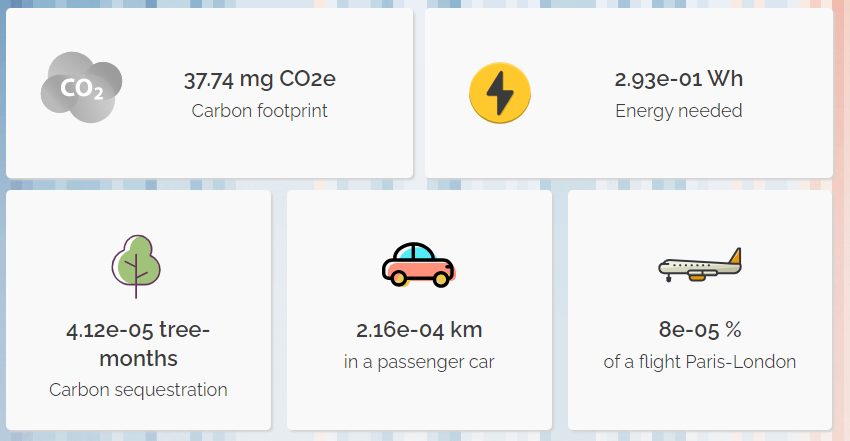

### C.1 Power Usage Efficiency (PUE)

PUE is the efficiency coefficient of the data center. If PUE is not given, Green Algorithms considers the world average value given in 2019 for servers: 1.67, but we recommend considering the 2022 average value: 1.55 <a name="cite_ref-4"></a>[[4]](#cite_note-4).

For personal computers we generally consider PUE=1, as there are no other important devices consuming power.

<span style="color:DarkRed">Q4. Recall what is PUE.
An important part of the non-IT consumption of a datacenter comes from air conditioning. What do you think about the relevance of using an average PUE?</span>

**Respuesta**

Un valor promedio de PUE no tomará en cuenta la eficiencia particular del datacenter en el cual estamos corriendo nuestro proyecto. Si, por ejemplo, el datacenter se encuentra en una zona cálida, o si el sistema de aire acondicionado es poco eficiente, posiblemente el sistema de aire acondicionado tenga un mayor consumo de energía para poder mantener los sistemas de enfriamiento necesarios, lo que puede hacer que el PUE aumente, en cuyo caso se estaría sobreestimando la eficiencia al considerar el promedio global. Por el contrario, si la zona es fría o el sistema de aire acondicioando es eficiente, considerar el promedio global podría llevar a una subestimación de la eficiencia.

<span style="color:DarkRed">Q5. For Google datacenters, the PUE is 1.1 <a name="cite_ref-5"></a>[[5]](#cite_note-5). Do you think this means every deep learning project should be run in Google datacenters? </span>

**Respuesta**

Si bien un valor de PUE de 1.1 es significativamente menor que el promedio global, pueden existir otras variables que entren en juego para decidir donde correr un proyecto. Por ejemplo, la contratación de servicios de Google puede resultar muy costosa, se puede tener datos sensibles que deban almacenarse en un servidor local, se puede necesitar alguna arquitectura o característica específica para el almacenamiento de los datos, o un control más estricto sobre los mismos, lo que se puede lograr más fácilmente con un servidor local, por ejemplo. Asimismo, si el proyecto es pequeño, se podría llegar a una eficiencia igual o mejor mediante un servidor local.

 Cabe destacar, además, que 1.1 corresponde al PUE promedio global de los servidores de Google, pero no necesariamente al PUE del servidor que se vaya a utilizar para correr nuestro proyecto. Si la variabilidad es grande, el PUE del datacenter real puede ser mayor.


The following image was taken from  <a name="cite_ref-6"></a>[[6]](#cite_note-6).

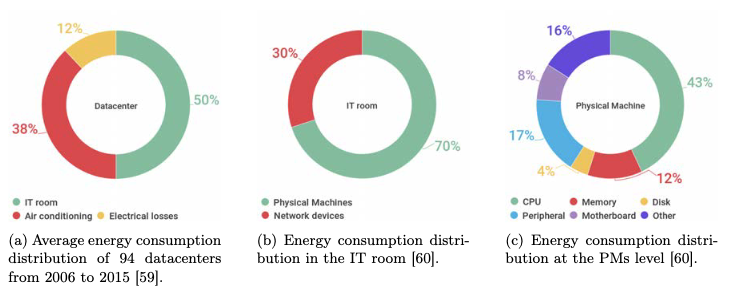


<span style="color:DarkRed">Q6. Assuming that the data center's electricity consumption follows this distribution, what proportion of the electricity consumption can be studied with Green Algorithms? Note that is this figure, only CPUs are considered, so it is not fully applicable to our case of study.</span>

<span style="color:DarkRed">Q7. What part of these figures are included in the PUE?</span>


**Respuestas**

**Q6**: La fórmula del consumo de energía durante la ejecución del programa computa la energía consumida por la computadora (memoria + núcleos), y luego la multiplica por el PUE. Dado que el PUE es igual al cociente entre la energía total utilizada por el datacenter y la consumida por los equipos de tecnología, el producto de ambas cantidades corresponde a un prorrateo de la energía total del datacenter correspondiente a la ejecución del programa en cuestión. De esta manera, se está considerando indirectamente todo el consumo de energía del datacenter. Particularmente, con la distribución de la imagen, dado que el consumo de energía del IT room corresponde al 50% del consumo total, el PUE del datacenter sería igual a 2, lo que significa que la mitad de la energía del datacenter es utilizada para alimentar los equipos de IT, mientras que la otra mitad es utilizada para las necesidades restantes. Al incluir este factor de 2 en el cálculo de la energía consumida por la computadora, se está considerando de manera indirecta la cantidad de energía adicional gastada por el datacenter, correspondiente a elementos distintos a los equipos de IT, asociada a los equipos utilizados para correr el programa computacional.

**Q7**: El PUE es el cociente entre la energía total utilizada por el datacenter y la energía consumida por los equipos de tecnología de la información (como servidores y equipos de red). En esta línea, las partes de las imágenes incluidas en el cálculo del PUE serían únicamente las correspondientes a la categoría "IT room", es decir, el 50% de la primera gráfica, correspondiente al 100% de la segunda y tercera gráfica.

### C.2 Pragmatic Scaling Factor

This parameter is used to indicate how many times we have executed the code with the indicated configuration.

<span style="color:DarkRed">Q8. What is the pragmatic scaling factor until now for this practice?
</span>

**Respuesta**

Dado que se corrió **TrainingClassification.py** y **TrainingClassification_withtime.py**, el PSF hasta ahora es 2.

### C.3 Location

Carbon footprint is affected by the location from where the code is being executed. The origin of the energy used is key when determining greenhouse emissions. If we are running in the cloud, and the provider has several datacenters around the planet, it is sometimes possible to choose where you want to run the code from.

We can check the execution location with the command:
- **Linux, Windows and MacOS**: `curl ipinfo.io`

> **Remark:** In the case of Colab, you cannot choose where to execute the codes. Nevertheless, you can also use previous command and then determine the datacenter where the ocde is executed with the following [link](https://cloud.google.com/about/locations?hl=es). We do not know in advance in which datacenter the virtual machine where the notebook will run will be created. It is necessary to execute the command every time we create or reset the runtime, since the location may change.

<span style="color:DarkRed">Q9. Run the following command and observe the result. What is the value of carbon intensity $CI$ used by Green Algorithm at the location where your code is running, according to [Green Algorithm](http://calculator.green-algorithms.org/)?</span>

In [ ]:
!curl ipinfo.io

{
  "ip": "34.147.93.185",
  "hostname": "185.93.147.34.bc.googleusercontent.com",
  "city": "Groningen",
  "region": "Groningen",
  "country": "NL",
  "loc": "53.2192,6.5667",
  "org": "AS396982 Google LLC",
  "postal": "9711",
  "timezone": "Europe/Amsterdam",
  "readme": "https://ipinfo.io/missingauth"
}

Carbon intensity varies according to location but also to other variables, such as the time of day of execution, or the distribution of energy sources at a given moment.  It is important to mention that Green Algorithms does not yet take the information of carbon intensity in real time. The carbon intensity data is taken from [this file](https://github.com/GreenAlgorithms/green-algorithms-tool/blob/master/data/latest/CI_aggregated.csv), where for each country or region the source of information is specified. These values are an average.

As additional information, carbon emissions of many countries can be checked in real time on the site https://app.electricitymaps.com/.

<span style="color:DarkRed">Q10. Compare the value of $CI$ you have just found with the one in real time from electrictymaps? What do you observe? Also compare with the last 24 hours and 30 days?</span>

**Respuestas**

**Q9**: Dado que el datacenter se encuentra en Holanda, el valor de CI es de 374.34	gCO2e/kWh

**Q10**: El valor real al tiempo de responder esta pregunta es de 281g, es decir, un 75% del considerado por GreenAlgorithm, lo que significa que la estimación de la huella de carbono mediante GreenAlgorithm seguramente sea una sobreestimación de la huella de carbono real.

Hace 24 horas, sin embargo, el valor de CI era de 126g, lo que implica que haber corrido el mismo código hace 24 horas hubiese generado una huella de carbono de aproximadamente la mitad, si se hubiese corrido en el mismo data center.

Hace 30 días, el valor de CI era de 359g, mayor al actual y al de hace 24 horas. Sin embargo, el valor mínimo en los últimos 30 días fue de 80g, correspondientes al 19 de setiembre. Haber corrido el mismo código ese día hubiese generado la menor huella de carbono posible de los últimos 30 días.


## D. Practice with CodeCarbon

[CodeCarbon](https://codecarbon.io) is a software package for Python. It estimates the amount of gas emissions produced by the execution of the code. CodeCarbon takes into account energy consumption and location to calculate the carbon footprint.

### Installation

Installing the library it's very easy using pip or conda.

<span style="color:red">Pre-install in cremi for students ?</span>

In [ ]:
!pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.9 MB/s eta 0:00:00


### Usage

There are several ways of using the library, but here we use the recommended way for notebooks, using the `start` and `stop` functions of the tracker. Other options can be found in the [documentation](https://mlco2.github.io/codecarbon/usage.html).

The package by default logs data into a CSV file named `emissions.csv` in the current directory.

In [ ]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker(tracking_mode="process")

tracker.start()
!python TrainingClassification.py
emissions: float = tracker.stop()

print('-----------------------------------------------------')
print('Total CPU energy consumption CodeCarbon (Process): ' + str(tracker._total_cpu_energy.kWh*1000) + ' Wh')
print('Total RAM energy consumption CodeCarbon (Process): ' + str(tracker._total_ram_energy.kWh*1000) + ' Wh')
print('Total GPU energy consumption CodeCarbon (Process): ' + str(tracker._total_gpu_energy.kWh*1000) + ' Wh')
print('Total Energy consumption CodeCarbon (Process): ' + str(tracker._total_energy.kWh*1000) + ' Wh')
print('Emissions by CodeCarbon (Process): '+ str(emissions*1000) + ' gCO2e')

[codecarbon INFO @ 02:19:10] [setup] RAM Tracking...
[codecarbon INFO @ 02:19:10] [setup] GPU Tracking...
[codecarbon INFO @ 02:19:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:19:10] [setup] CPU Tracking...
[codecarbon WARNING @ 02:19:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 02:19:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 02:19:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 02:19:11] >>> Tracker's metadata:
[codecarbon INFO @ 02:19:11]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 02:19:11]   Python version: 3.10.12
[codecarbon INFO @ 02:19:11]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 02:19:11]   Available RAM : 12.678 GB
[codecarbon INFO @ 02:19:11]   CPU count: 2
[codecarbon INFO @ 02:19:11]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 02:19:11]   GPU

Epoch [1/5], Train Loss: 1.9755, Train Acc: 0.5061, Val Loss: 1.5038, Val Acc: 0.6603


[codecarbon INFO @ 02:19:26] Energy consumed for RAM : 0.000004 kWh. RAM Power : 0.9610190391540527 W
[codecarbon INFO @ 02:19:26] Energy consumed for all GPUs : 0.000103 kWh. Total GPU Power : 24.61548776929157 W
[codecarbon INFO @ 02:19:26] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:26] 0.000284 kWh of electricity used since the beginning.


Epoch [2/5], Train Loss: 1.1588, Train Acc: 0.7497, Val Loss: 0.8935, Val Acc: 0.8123


[codecarbon INFO @ 02:19:41] Energy consumed for RAM : 0.000008 kWh. RAM Power : 0.9610533714294435 W
[codecarbon INFO @ 02:19:41] Energy consumed for all GPUs : 0.000215 kWh. Total GPU Power : 26.98853255542736 W
[codecarbon INFO @ 02:19:41] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:41] 0.000577 kWh of electricity used since the beginning.


Epoch [3/5], Train Loss: 0.7729, Train Acc: 0.8282, Val Loss: 0.6587, Val Acc: 0.8502
Epoch [4/5], Train Loss: 0.6088, Train Acc: 0.8559, Val Loss: 0.5442, Val Acc: 0.8700


[codecarbon INFO @ 02:19:56] Energy consumed for RAM : 0.000012 kWh. RAM Power : 0.9610848426818848 W
[codecarbon INFO @ 02:19:56] Energy consumed for all GPUs : 0.000329 kWh. Total GPU Power : 27.41546444713011 W
[codecarbon INFO @ 02:19:56] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:56] 0.000873 kWh of electricity used since the beginning.


Epoch [5/5], Train Loss: 0.5204, Train Acc: 0.8726, Val Loss: 0.4757, Val Acc: 0.8828


[codecarbon INFO @ 02:20:04] Energy consumed for RAM : 0.000012 kWh. RAM Power : 0.0611114501953125 W
[codecarbon INFO @ 02:20:04] Energy consumed for all GPUs : 0.000386 kWh. Total GPU Power : 27.41866258941917 W
[codecarbon INFO @ 02:20:04] Energy consumed for all CPUs : 0.000620 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:20:04] 0.001018 kWh of electricity used since the beginning.


-----------------------------------------------------
Total CPU energy consumption CodeCarbon (Process): 0.6196001710163223 Wh
Total RAM energy consumption CodeCarbon (Process): 0.01213726530560895 Wh
Total GPU energy consumption CodeCarbon (Process): 0.38607836441799986 Wh
Total Energy consumption CodeCarbon (Process): 1.0178158007399312 Wh
Emissions by CodeCarbon (Process): 0.39562703737921273 gCO2e


Information about the infrastructure of the platform used can be seen on the standard output. The output also indicates the energy consumed by the components and the resulting emissions.

> **Remark 1:** CPUs tracking uses RAPL files or Power Gadget (only for INTEL CPUs with root access). The consumption reported by RAPL files or Power Gadget represents the consumption of the whole machine, and not only the process. If CodeCarbon cannot find the software to track the CPUs, then the tool uses the model of CPU to search in a list the corresponding TDP. If the model is unknown, it uses a TDP of 85W. This assumption can lead to reporting values of carbon emissions that are not real.

> **Remark 2:** GPUs tracking uses `pynvml` library (only for NVIDIA GPUs). CodeCarbon does not measure consumption of *non-NVIDIA GPUs*. The consumption reported by pynvml represents the consumption of the whole machine, and not only the process.

> **Remark 3:** Energy consumption by memory is 0.375W/GB of memory used. If tracking mode is *process*, the memory used by the process is measured via `psutil`.

## C. Comparing Green Algorithms and CodeCarbon

<span style="color:DarkRed">Q11. Compare the results of both tools. Why are there some differences? What advantages and disadvantages do you see in using each tool? </span>


**Respuestas**

Considerando los mismos valores utilizados para el cálculo anterior, pero especificando que el servidor está ubicado en Holanda (europe-west4), se obtiene un consumo de energía es de **0.325Wh**, con una huella de carbono de **121.58mgCO2e**.

Por el otro lado, el consumo de energía calculado por CodeCarbon es de 1.018Wh, con una huella de carbono de 396mgCO2e.

En primer lugar, se destaca que el valor de intensidad de carbono de que utilizan ambos métodos es distinto. Para el datacenter de Gronigen, Holanda, el CI utilizado por CodeCarbon es de 282 [(ver link)](https://github.com/mlco2/codecarbon/blob/master/codecarbon/data/cloud/impact.csv), mientras que el utilizado por GreenAlgorithm es de 374.34, como fue dicho indicado anteriormente. Es decir, hay un 33% de diferencia entre ambos valores.

Otra razón por la cual pueden haber diferencias es que, como se ve del output del programa así como en el archivo de emissions.csv, CodeCarbon no reconoce el CPU, por lo que utilizará un TDP de por defecto de 85W, mientras que GreenAlgorithm utiliza un promedio de 12W. En esta línea, si se mira el archivo emissions.csv, se puede ver que el PUE considerado por CodeCarbon es de 1.0, mientras que el especificado en GreenAlgorithm es de 1.11, lo que agrega aún más diferencias a los resultados.

La ventaja más clara de CodeCarbon respecto a GreenAlgorithm radica en su facilidad de uso, pudiendo obtener valores rápidos de consumos energéticos y huella de carbono en pocas líneas de código. Sin embargo, la facilidad de uso también hace posible que se obtengan valores irreales sin que el usuario pueda darse cuenta, como puede ocurrir si el modelo de CPU utilizado no es encontrado (y por tanto se utiliza un TDP de 85W, como en este caso). Por el otro lado, si bien GreenAlgorithm es un poco más difícil de usar, también es más transparente a la hora de hacer los cálculos, pudiendo especificar todos los parámetros incluidos en ellos. Particularmente, se destaca el hecho de poder incluir el valor del PUE de acuerdo a la ubicación del datacenter utilizado, mientras que CodeCarbon considera un valor de 1.0, es decir, no considera la eficiencia real del datacenter en el cual se corre el código. Por último, se destaca una desventaja compartida por ambos métodos. Ninguno de los dos métodos permite considerar intensidad de carbono en tiempo real. Dado que esta cantidad puede variar significativamente en tiempos cortos, la precisión en este parámetro resulta bastante importante para la correcta estimación de la huella de carbono.

## References


<a name="cite_note-1"></a>[1] [^](#cite_ref-1) M.Hodak,M.Gorkovenko,and A.Dholakia,“Towards power efficiency in deep learning on data center hardware,” 2019 IEEE International Conference on Big Data (Big Data), pp. 1814–1820, 2019.

<a name="cite_note-2"></a>[2] [^](#cite_ref-2) https://www.tomshardware.com/reviews/intel-core-i7-5960x-haswell-e-cpu,3918-13.html

<a name="cite_note-3"></a>[3] [^](#cite_ref-3) Wikipedia: https://en.wikipedia.org/wiki/Time_(Unix)

<a name="cite_note-4"></a>[4] [^](#cite_ref-4) Uptime Institute (https://uptimeinstitute.com/uptime_assets/6768eca6a75d792c8eeede827d76de0d0380dee6b5ced20fde45787dd3688bfe-2022-data-center-industry-survey-en.pdf)

<a name="cite_note-5"></a>[5] [^](#cite_ref-5) https://www.google.com/about/datacenters/efficiency/

<a name="cite_note-6"></a>[6] [^](#cite_ref-6) David Guyon. Supporting energy-awareness for cloud users. Networking and Internet Architecture, Université Rennes 1, 2018

<a name="cite_note-7"></a>[7] [^](#cite_ref-7)Patterson et al., The Carbon Footprint of Machine Learning Training Will Plateau, Then Shrink, arXiv:2204.05149, 2022

<a name="cite_note-7"></a>[7] [^](#cite_ref-7)Patterson et al., The Carbon Footprint of Machine Learning Training Will Plateau, Then Shrink, arXiv:2204.05149, 2022


<a name="cite_note-8"></a>[8] [^](#cite_ref-8) Bouza et al., How to estimate carbon footprint when training deep learning models? A guide and review arXiv:2306.08323, 2023


